In [1]:
import sys
import os
from datetime import datetime
import time
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
pd.set_option('display.max_rows', None)
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb


In [2]:
sys.path.append(os.path.abspath('../src'))
from lib import (
    train_and_evaluate_models,
    create_eui_comparison_plots,
    evaluate_model_strategies,
    calculate_average_metrics,
    create_error_distribution_plots
)

In [3]:
output_path = "../data/03_processed/merged_df.csv"
merged_df = pd.read_csv(output_path)
merged_df = merged_df.rename(columns={'total_year': 'hdd_total_year'})

# GDP per capita
merged_df['GDP_per_capita'] = merged_df['GDP_2022'] / merged_df['Population_2023']

# Delete Taiwan (temporal)
merged_df = merged_df[merged_df['Country'] != 'Taiwan']

#np.random.seed(123)
#merged_df['is_train'] = np.random.choice([1, 0], size=len(merged_df), p=[0.8, 0.2])

# Train / Test

In [4]:
train_test_split_original_data_path = "../data/03_processed/train_test_split_original_data.csv"
train_test_split_original_data = pd.read_csv(train_test_split_original_data_path)

train_test_split_new_data_path = "../data/03_processed/train_test_split_new_data.csv"
train_test_split_new_data = pd.read_csv(train_test_split_new_data_path)

train_test_split = pd.concat([train_test_split_original_data, train_test_split_new_data], ignore_index=True)

merged_df = merged_df.merge(train_test_split, on=['index', 'geonameid'], how='left')

# We want to keep original data 
merged_df = merged_df[merged_df["source"] == "World Bank CURB"]

In [5]:
features = [
    "hdd_total_year", 
    "cdd_total_year", 
    "GDP_per_capita", 
    "Urbanization_Rate_2022",
    #"latitude",
    #"longitude",  
    "Paris_Agreement",
    "Subnational HDI", 
    "Educational index", 
    "Income index",
    "2m_temperature_2023_avg",
    "2m_dewpoint_temperature_2023_avg",
    "total_precipitation_2023",
    "longitude_sin", 
    "longitude_cos", 
    "latitude_sin", 
    "latitude_cos",  
    "population_density"
]

feature_abbreviations = {
    "hdd_total_year": "HDD",
    "cdd_total_year": "CDD", 
    "GDP_per_capita": "GDP",
    "Urbanization_Rate_2022": "URB",
   # "latitude": "Lat",
   # "longitude": "Long",
    "Paris_Agreement": "Paris",
    "Subnational HDI": "HDI", 
    "Educational index": "EDU" , 
    "Income index": "Income",
    "2m_temperature_2023_avg": "Temp",
    "2m_dewpoint_temperature_2023_avg": "Dew",
    "total_precipitation_2023": "Precip",
    "longitude_sin": "Long_Sin", 
    "longitude_cos": "Long_Cos", 
    "latitude_sin": "Lat_Sin", 
    "latitude_cos": "Lat_Cos",  
    "population_density": "Pop_Dens"
}

target_columns = [
    "Residential EUI (kWh/m2/year)",
    "Non-residential EUI (kWh/m2/year)"
]

regions = ['Asia & Oceania', 'Europe', 'Africa', 'Central and South America', 'Northern America']


# XGBoost

In [6]:
# XGBoost parameters
xgb_params = {
    'n_estimators': 100,
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 1,
    'random_state': 42,
    'objective': 'reg:squarederror'
}


### XGBoost - Within Domain

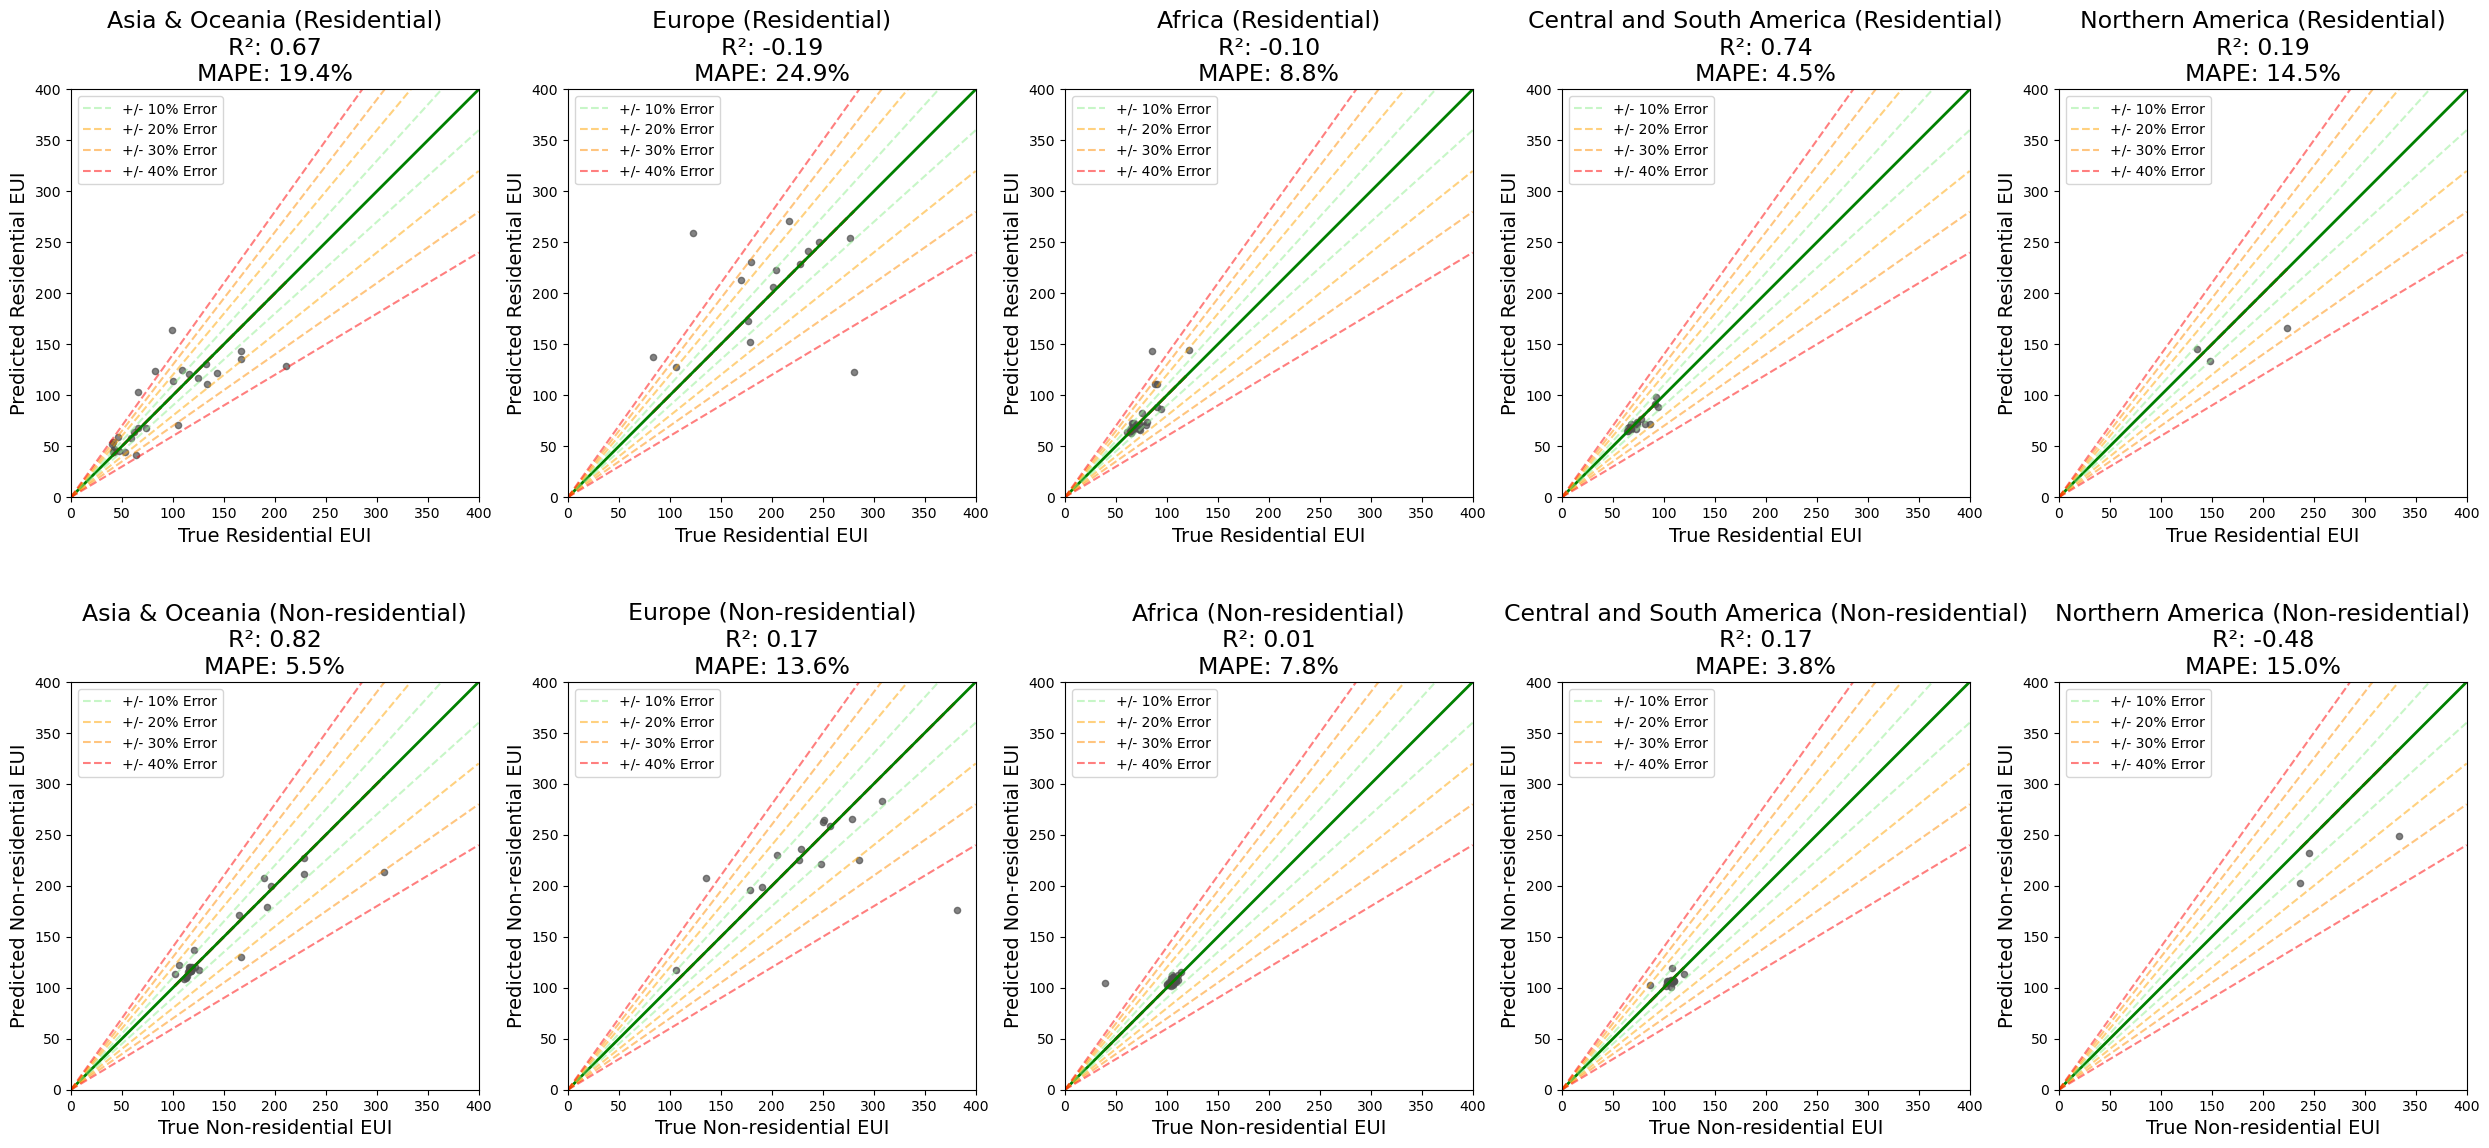

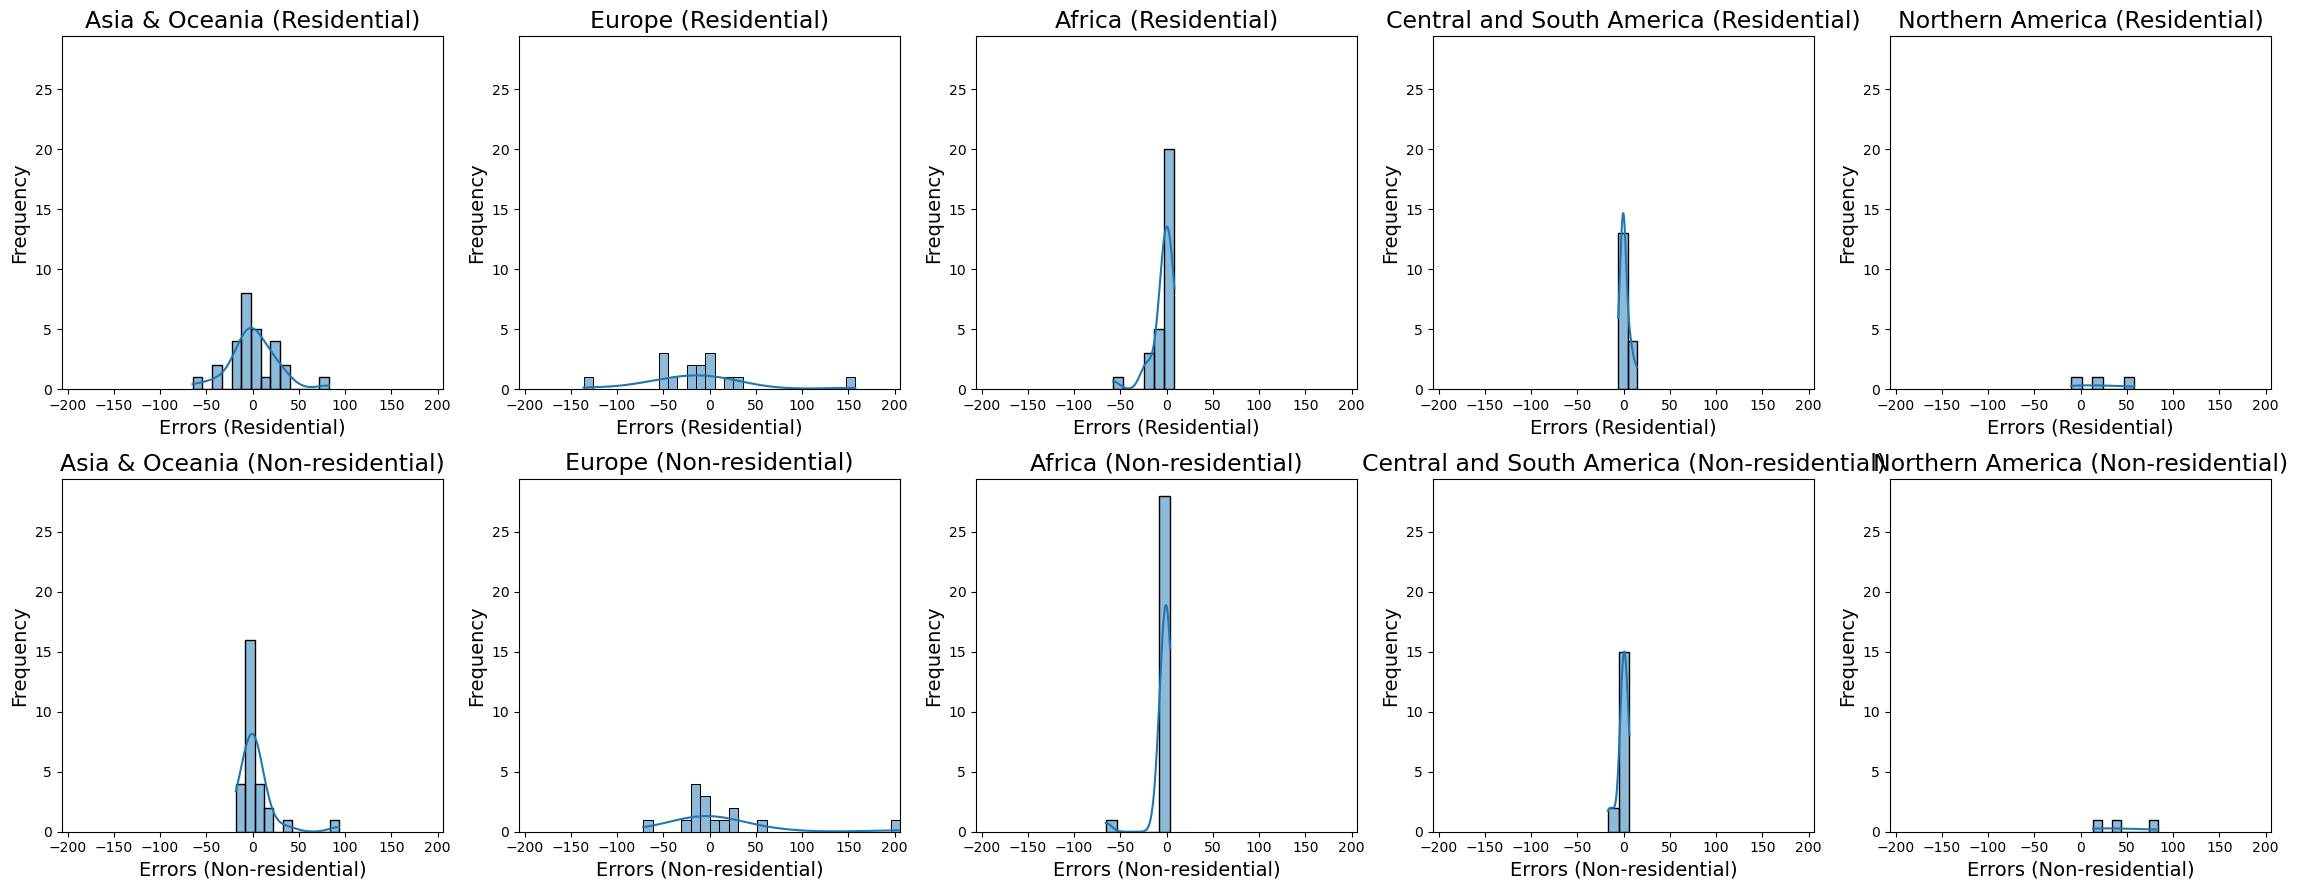

In [7]:
model_xgb_within = xgb.XGBRegressor(**xgb_params)
results_xgb_within = train_and_evaluate_models(
    merged_df=merged_df,
    regions=regions,
    features=features,
    model=model_xgb_within,
    strategy='within_domain'
)

create_eui_comparison_plots(results_xgb_within, 
    save_path='../figures/model_plots/xgb_within_domain_eui_predictions.png')

create_error_distribution_plots(results_xgb_within,
    save_path='../figures/model_plots/xgb_within_domain_error_distribution.png')

### XGBoost - Cross Domain

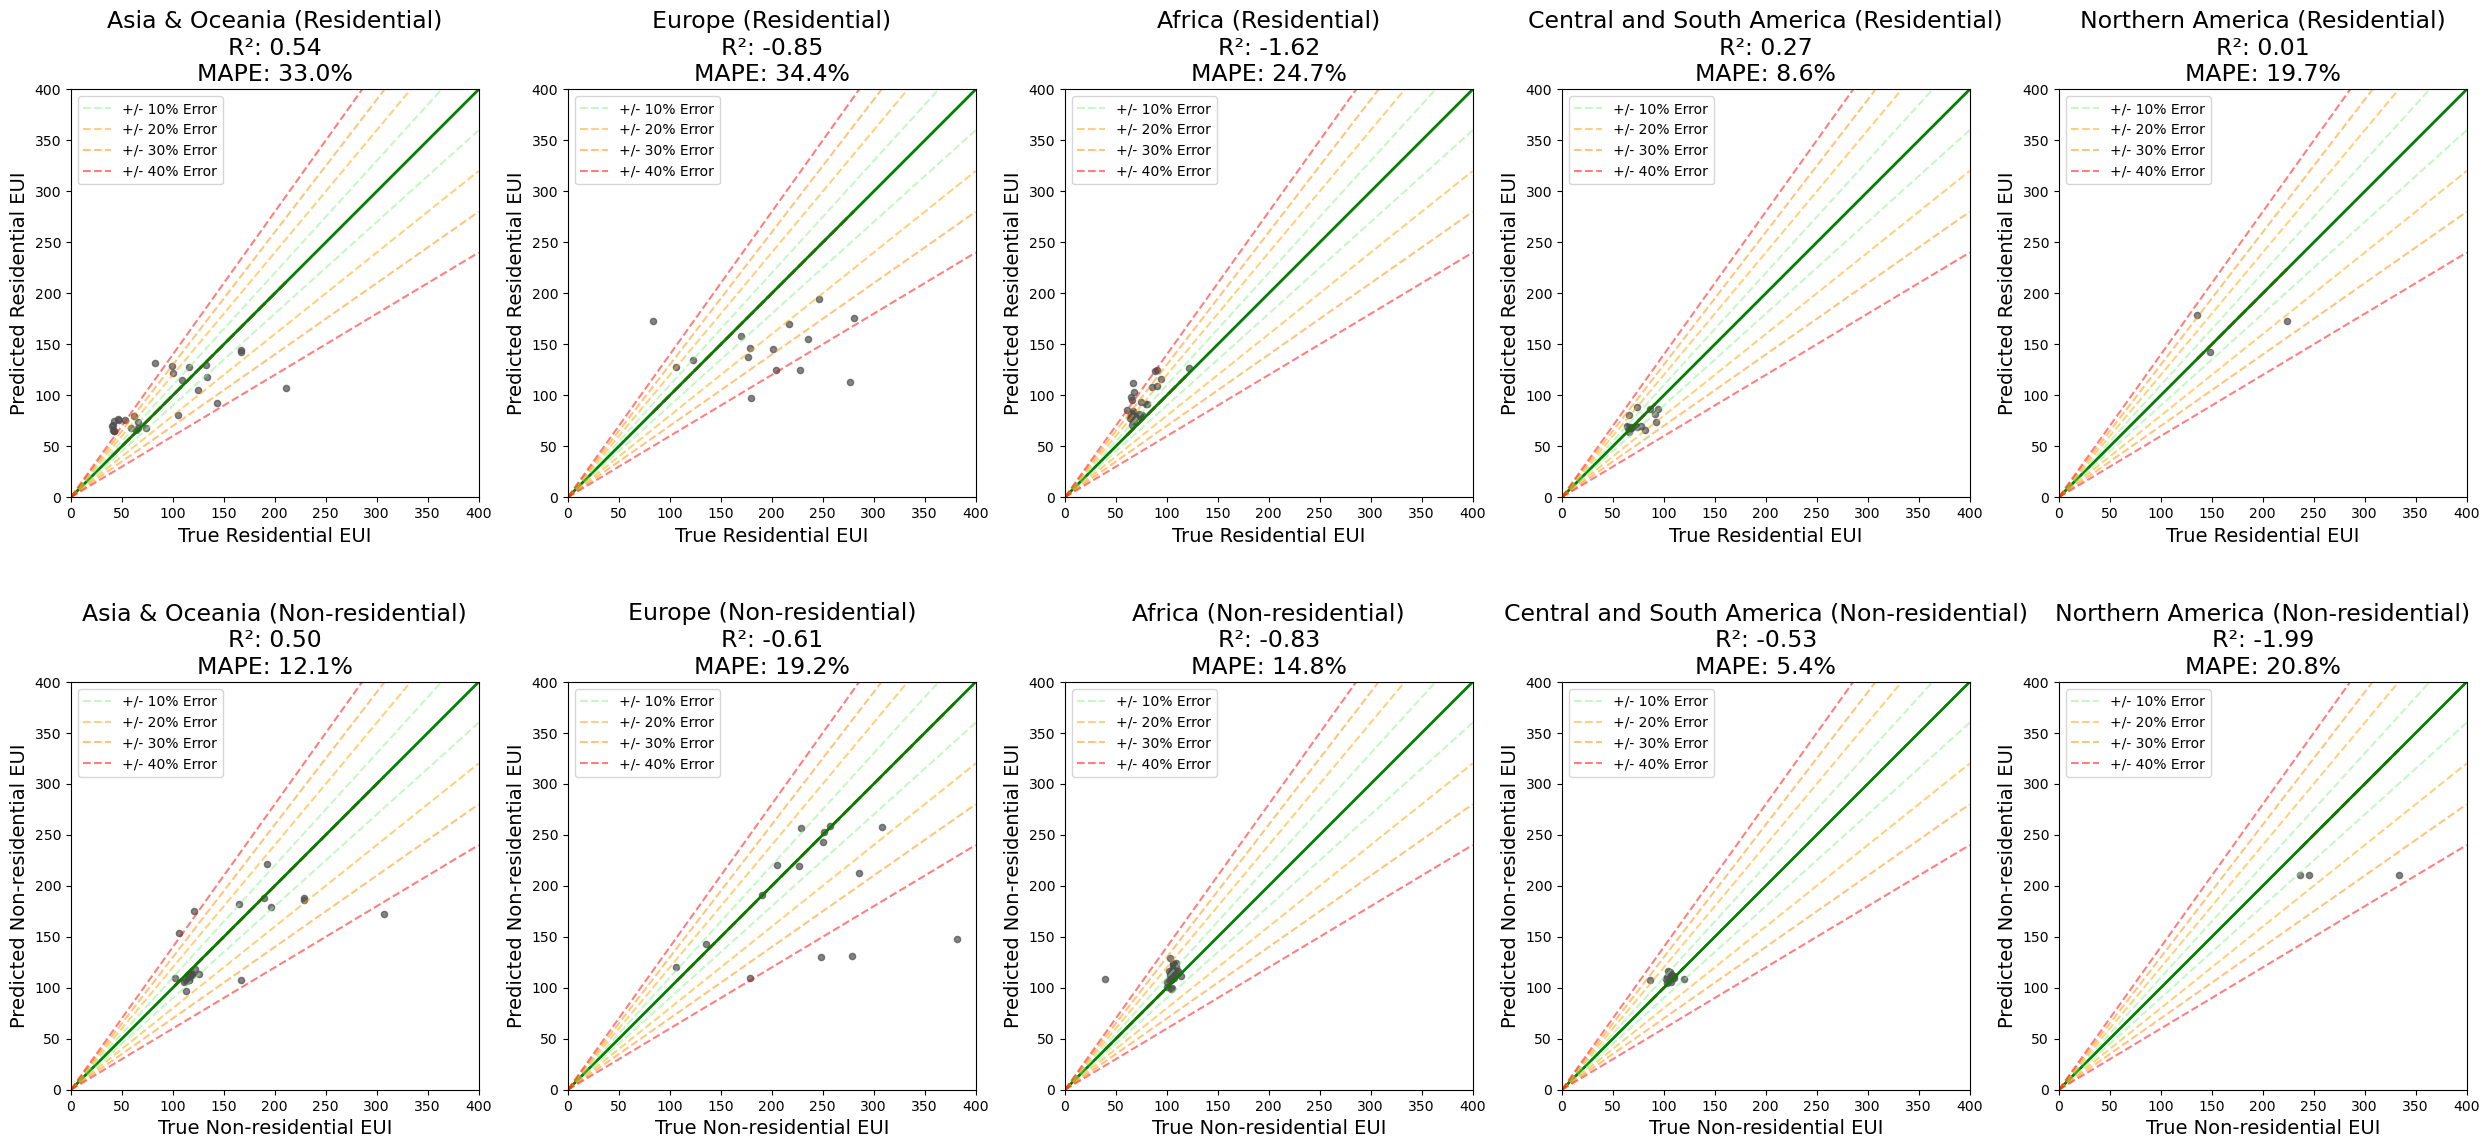

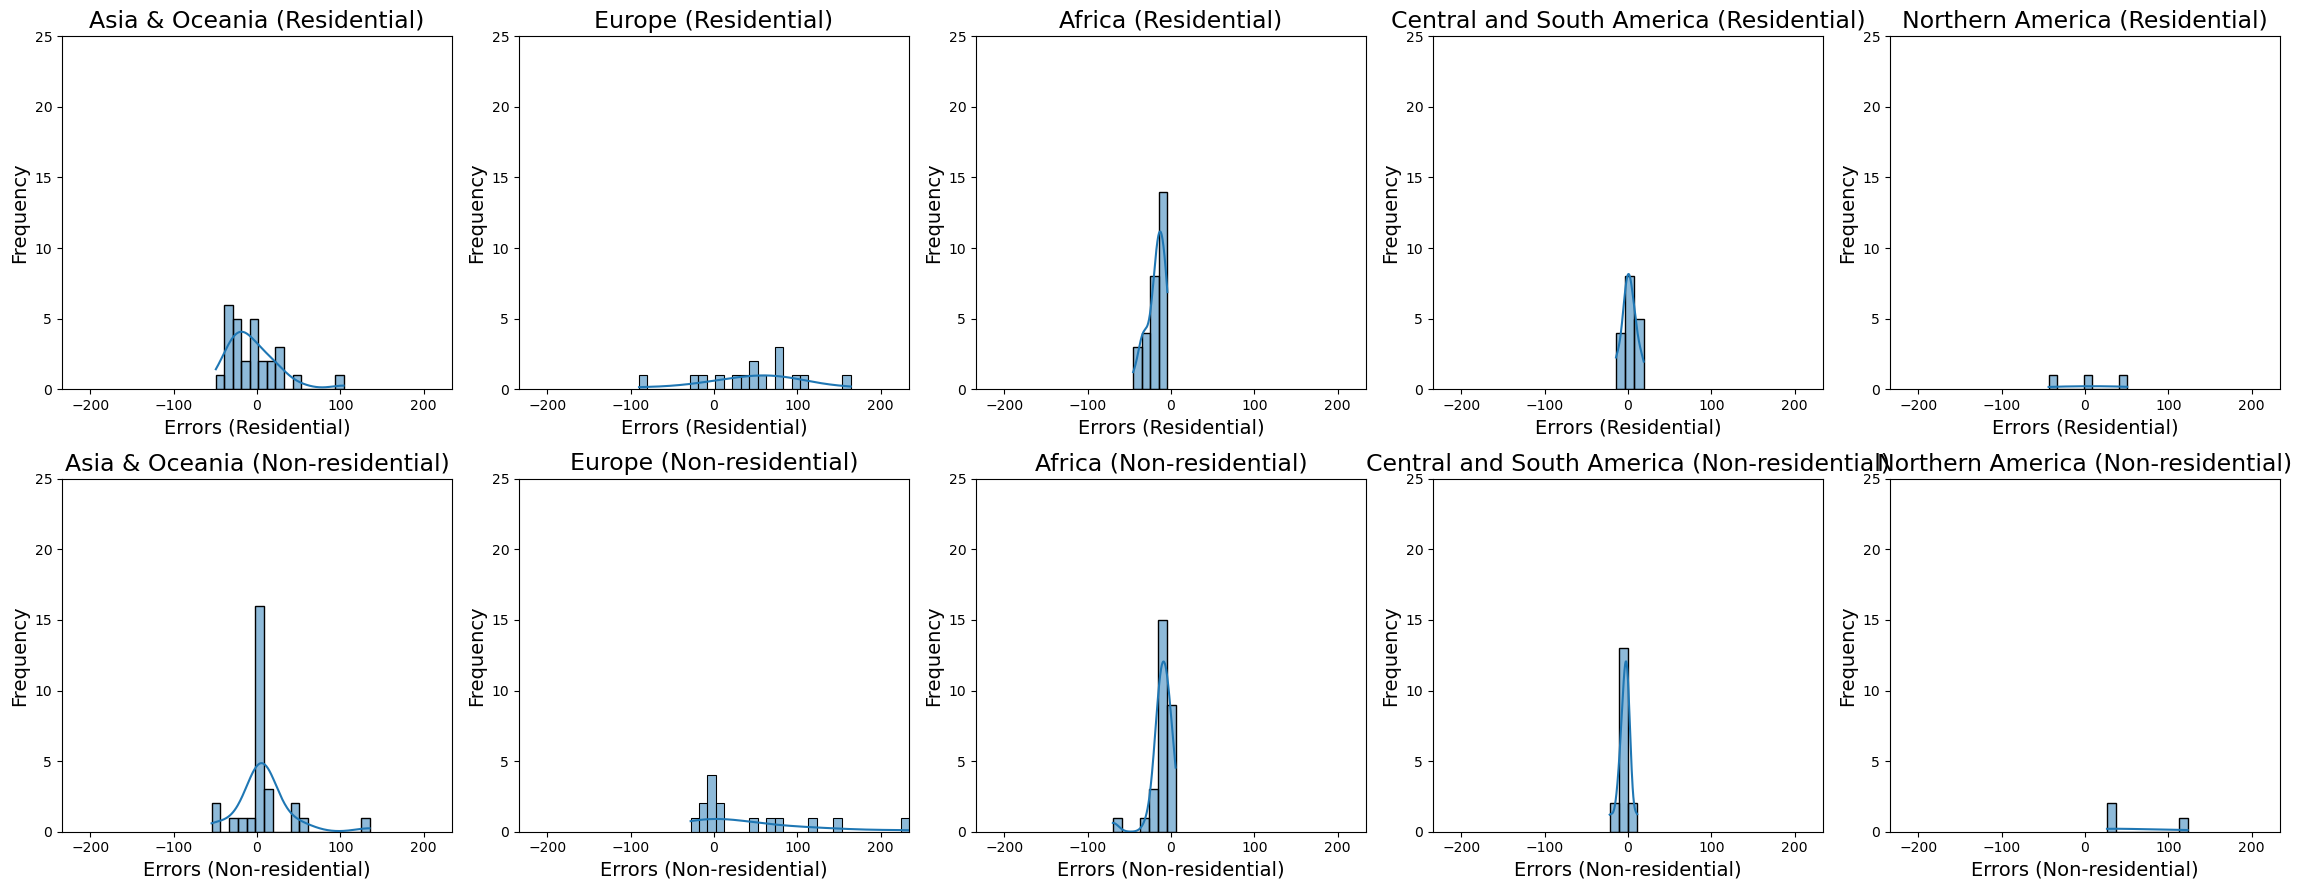

In [8]:
# Cross-domain
model_xgb_cross = xgb.XGBRegressor(**xgb_params)
results_xgb_cross = train_and_evaluate_models(
    merged_df=merged_df,
    regions=regions,
    features=features,
    model=model_xgb_cross,
    strategy='cross_domain'
)

create_eui_comparison_plots(results_xgb_cross,
    save_path='../figures/model_plots/xgb_cross_domain_eui_predictions.png')

create_error_distribution_plots(results_xgb_cross,
    save_path='../figures/model_plots/xgb_cross_domain_error_distribution.png')


### XGBoost - All Domain

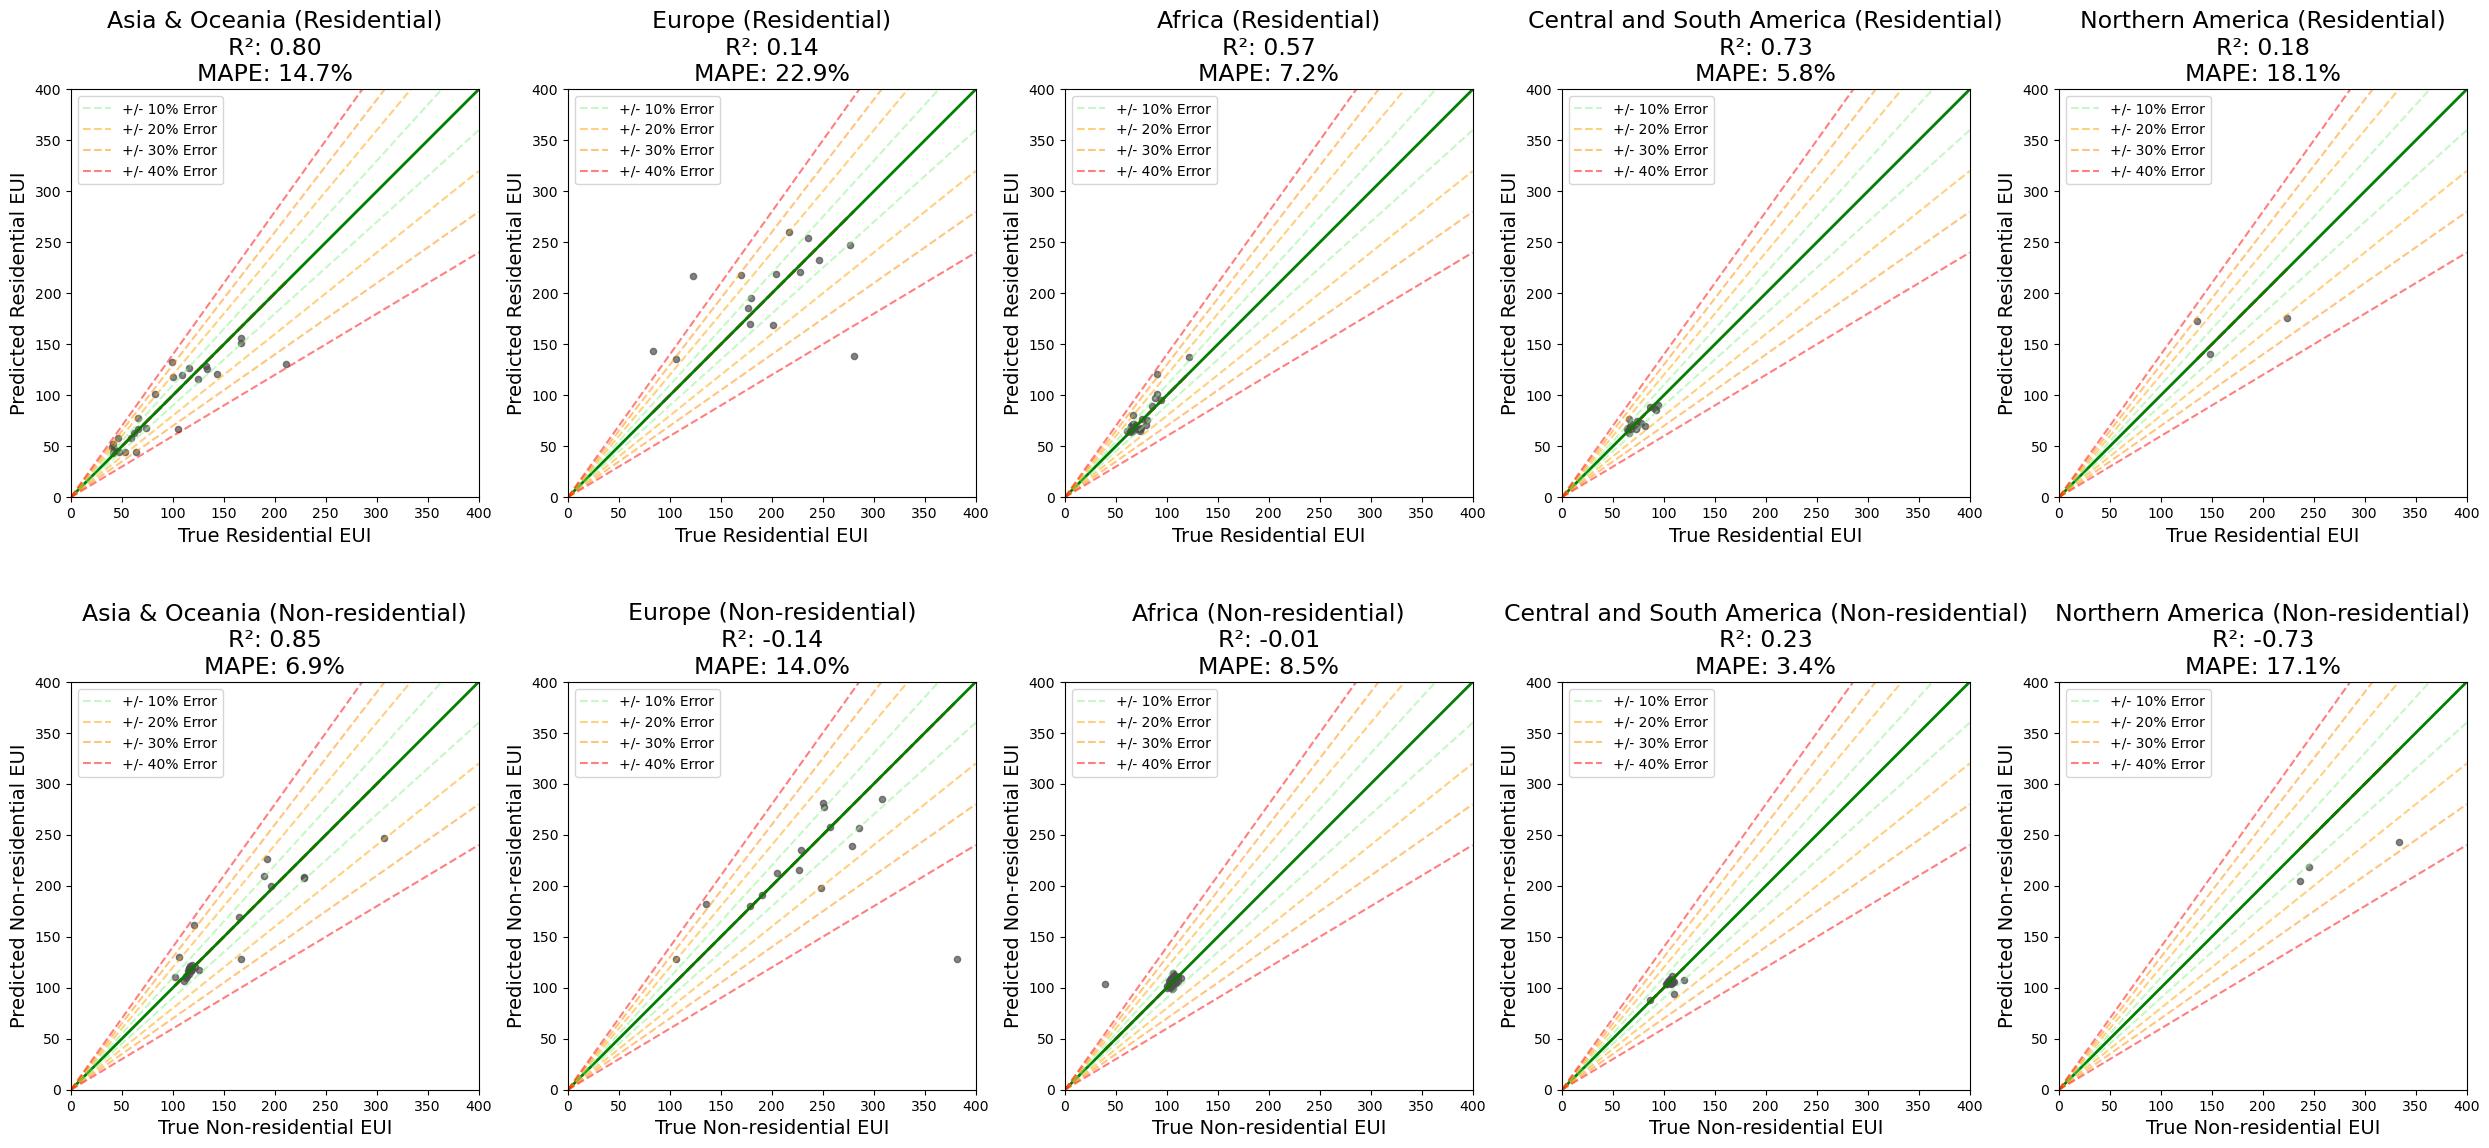

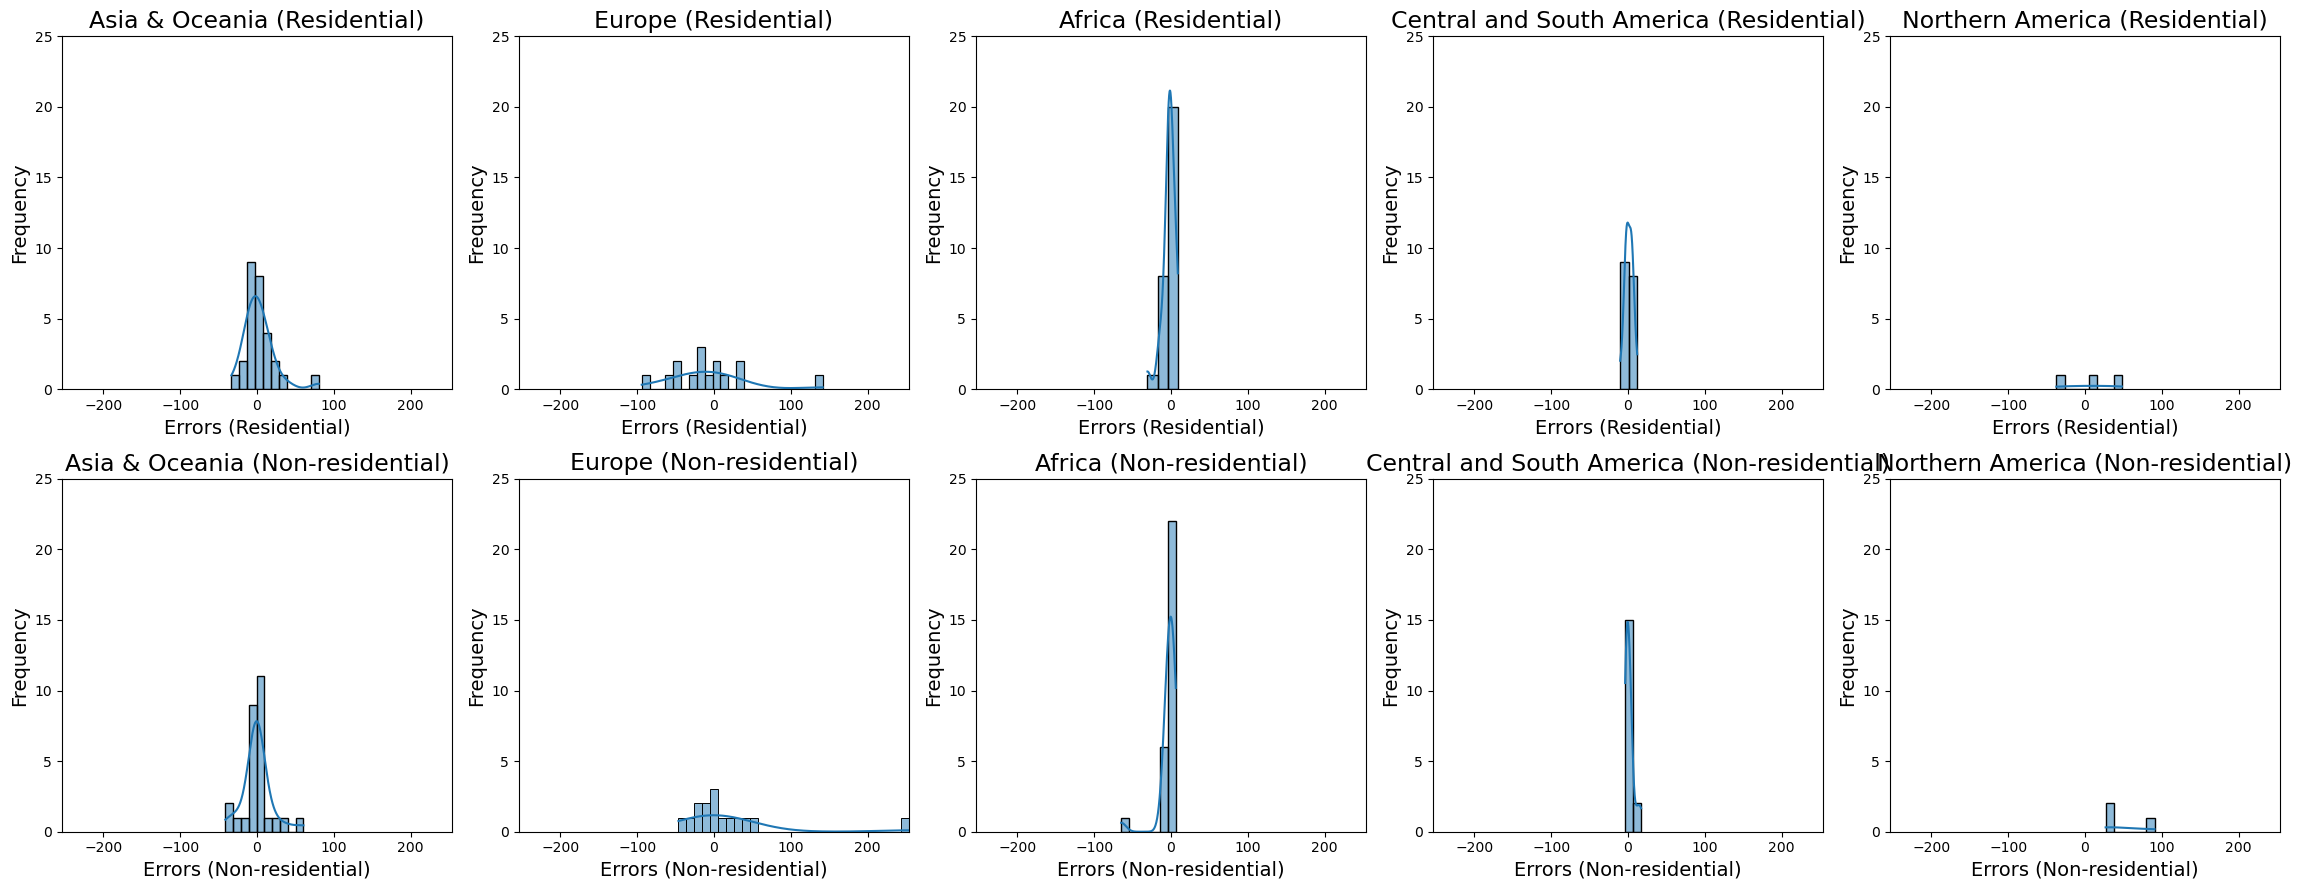

In [9]:
# All-domain
model_xgb_all = xgb.XGBRegressor(**xgb_params)
results_xgb_all = train_and_evaluate_models(
    merged_df=merged_df,
    regions=regions,
    features=features,
    model=model_xgb_all,
    strategy='all_domain'
)

create_eui_comparison_plots(results_xgb_all,
    save_path='../figures/model_plots/xgb_all_domain_eui_predictions.png')

create_error_distribution_plots(results_xgb_all,
    save_path='../figures/model_plots/xgb_all_domain_error_distribution.png')

In [10]:
XGBModel = lambda: xgb.XGBRegressor(**xgb_params)

xgb_detailed_results = evaluate_model_strategies(
    merged_df=merged_df,
    regions=regions,
    features=features,
    model_type=XGBModel,  # Usar XGBModel en lugar de xgb.XGBRegressor
    feature_abbreviations=feature_abbreviations,
    model_details=", ".join(f"{k}={v}" for k, v in xgb_params.items())
)
xgb_detailed_results['Model'] = 'XGBRegressor'

xgb_average_results = calculate_average_metrics(xgb_detailed_results).reset_index()
xgb_average_results

,Target,Strategy,Model,Model Details,Features Used,Features Abbreviated,MAPE,R²,MSE,RMSE,MAE,WAPE
0,Non-residential EUI (kWh/m2/year),within_domain,XGBRegressor,"n_estimators=100, max_depth=6, learning_rate=0...","hdd_total_year, cdd_total_year, GDP_per_capita...",HDD | CDD | GDP | URB | Paris | HDI | EDU | In...,9.14,0.137,1407.259,30.391,19.060,9.00
1,Non-residential EUI (kWh/m2/year),cross_domain,XGBRegressor,"n_estimators=100, max_depth=6, learning_rate=0...","hdd_total_year, cdd_total_year, GDP_per_capita...",HDD | CDD | GDP | URB | Paris | HDI | EDU | In...,14.46,-0.690,2835.691,43.596,30.020,14.98
2,Non-residential EUI (kWh/m2/year),all_domain,XGBRegressor,"n_estimators=100, max_depth=6, learning_rate=0...","hdd_total_year, cdd_total_year, GDP_per_capita...",HDD | CDD | GDP | URB | Paris | HDI | EDU | In...,9.98,0.038,1761.502,33.005,21.305,10.06
3,Residential EUI (kWh/m2/year),within_domain,XGBRegressor,"n_estimators=100, max_depth=6, learning_rate=0...","hdd_total_year, cdd_total_year, GDP_per_capita...",HDD | CDD | GDP | URB | Paris | HDI | EDU | In...,14.42,0.263,1170.315,28.222,19.327,14.36
4,Residential EUI (kWh/m2/year),cross_domain,XGBRegressor,"n_estimators=100, max_depth=6, learning_rate=0...","hdd_total_year, cdd_total_year, GDP_per_capita...",HDD | CDD | GDP | URB | Paris | HDI | EDU | In...,24.08,-0.330,1758.282,35.131,29.367,22.64
5,Residential EUI (kWh/m2/year),all_domain,XGBRegressor,"n_estimators=100, max_depth=6, learning_rate=0...","hdd_total_year, cdd_total_year, GDP_per_capita...",HDD | CDD | GDP | URB | Paris | HDI | EDU | In...,13.74,0.482,896.953,24.374,18.460,13.32


In [11]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
xgb_detailed_results.to_csv(f'../results/{timestamp}_xgb_detailed_results.csv')
xgb_average_results.to_csv(f'../results/{timestamp}_xgb_average_results.csv')

# 